In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from scipy import stats

# 1. A quick look at the data

In [2]:
df = pd.read_csv('house-prices.csv')

In [3]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,142,535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,2042,903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


In [4]:
df.shape

(2430, 82)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2430 non-null   int64  
 1   PID              2430 non-null   int64  
 2   MS SubClass      2430 non-null   int64  
 3   MS Zoning        2430 non-null   object 
 4   Lot Frontage     2010 non-null   float64
 5   Lot Area         2430 non-null   int64  
 6   Street           2430 non-null   object 
 7   Alley            163 non-null    object 
 8   Lot Shape        2430 non-null   object 
 9   Land Contour     2430 non-null   object 
 10  Utilities        2430 non-null   object 
 11  Lot Config       2430 non-null   object 
 12  Land Slope       2430 non-null   object 
 13  Neighborhood     2430 non-null   object 
 14  Condition 1      2430 non-null   object 
 15  Condition 2      2430 non-null   object 
 16  Bldg Type        2430 non-null   object 
 17  House Style   

# 2. Exploratory data analysis and data cleaning

In [6]:
### Replace the white space and "/" in the columns with "_"
df.columns = df.columns.str.replace(' ', '_').str.replace('/', '_')

In [7]:
### Check for duplicates
df.duplicated().sum()

0

## 2.1 Find and handle incorrect, missing values

In [8]:
### Check the columns that contain missing values
df.columns[df.isna().sum() > 0]

Index(['Lot_Frontage', 'Alley', 'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Bsmt_Qual',
       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1',
       'BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'Electrical', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Fireplace_Qu',
       'Garage_Type', 'Garage_Yr_Blt', 'Garage_Finish', 'Garage_Cars',
       'Garage_Area', 'Garage_Qual', 'Garage_Cond', 'Pool_QC', 'Fence',
       'Misc_Feature'],
      dtype='object')

In [9]:
### Check the percentage of missing values in the variables
df.isna().sum()[df.columns[df.isna().sum() > 0]].sort_values(ascending=False)/df.shape[0]

Pool_QC           0.995062
Misc_Feature      0.962963
Alley             0.932922
Fence             0.798765
Mas_Vnr_Type      0.601646
Fireplace_Qu      0.488066
Lot_Frontage      0.172840
Garage_Cond       0.056790
Garage_Qual       0.056790
Garage_Finish     0.056790
Garage_Yr_Blt     0.056790
Garage_Type       0.055967
Bsmt_Exposure     0.030453
BsmtFin_Type_2    0.029630
Bsmt_Cond         0.029218
Bsmt_Qual         0.029218
BsmtFin_Type_1    0.029218
Mas_Vnr_Area      0.008230
Bsmt_Half_Bath    0.000823
Bsmt_Full_Bath    0.000823
BsmtFin_SF_1      0.000412
Garage_Cars       0.000412
Garage_Area       0.000412
Total_Bsmt_SF     0.000412
Bsmt_Unf_SF       0.000412
BsmtFin_SF_2      0.000412
Electrical        0.000412
dtype: float64

There are the columns `Pool_QC`, `Misc_Feature` and `Alley` that contain more than the 90% of the missing values.  
`Fence` contains about the 80% of missing values.  
The dataset contains 2430 rows, removing the missing values in these columns will result in a short dataset.  
Maybe missing values correspond to the houses that do not have that specific furniture.  
It is necessary to fill the missing values in one column with the other related columns to understand if the house has that feature or it does not.

### 2.1.1 Handle missing values in numerical features

In [10]:
### Select numerical columns
numerical_columns = [x for x in df.columns if df[x].dtypes != 'object']

In [11]:
### Check the percentage of missing values in the numerical variablesz
df[numerical_columns].isna().sum()[df[numerical_columns].columns[df[numerical_columns].isna().sum() > 0]].sort_values(ascending=False)/df.shape[0]

Lot_Frontage      0.172840
Garage_Yr_Blt     0.056790
Mas_Vnr_Area      0.008230
Bsmt_Full_Bath    0.000823
Bsmt_Half_Bath    0.000823
BsmtFin_SF_1      0.000412
BsmtFin_SF_2      0.000412
Bsmt_Unf_SF       0.000412
Total_Bsmt_SF     0.000412
Garage_Cars       0.000412
Garage_Area       0.000412
dtype: float64

#### 2.1.1.1 Compare the garage columns
If the house does not have a garage, all the numerical columns corresponding to that should be 0.  

In [12]:
### Create a numerical "garage" list
garage_num_columns = ['Garage_Yr_Blt', 'Garage_Cars', 'Garage_Area']
### Fill the numerical missing values with 0
df.loc[df[(df[garage_num_columns] == 0).any(axis=1) == True].index, garage_num_columns] = 0
### Fill the remaining missing values with the median
df[garage_num_columns] = df[garage_num_columns].fillna(df[garage_num_columns].median())

#### 2.1.1.2 Compare the basement columns
`Total_Bsmt_SF` represents the total square feet of basement area. If it is zero there is no basement

In [13]:
### Create a numerical "basement" list
bsmt_num_columns = ['BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath']
### Fill the numerical missing values with 0
df.loc[df[df['Total_Bsmt_SF'] == 0].index, bsmt_num_columns] = 0
### Fill the remaining missing values with the median
df[bsmt_num_columns] = df[bsmt_num_columns].fillna(df[bsmt_num_columns].median())

In [14]:
### Check the missing values in the numerical variables after removing the missing values
df[numerical_columns].isna().sum()[df[numerical_columns].columns[df[numerical_columns].isna().sum() > 0]].sort_values(ascending=False)

Lot_Frontage    420
Mas_Vnr_Area     20
dtype: int64

`Lot_Frontage` dos not have any relation with the others variables.  
`Mas_Vnr_Area` is related with `Mas_Vnr_Type` that it is a categorical variable and will be analyzed later.  
These two remaining features will be corrected with a pipeline.

### 2.1.2 Handle missing values in categorical features

In [15]:
### Select categorical columns 
categorical_columns = [x for x in df.columns if df[x].dtypes == 'object']

In [16]:
### Check the percentage of missing values in the numerical variablesz
df[categorical_columns].isna().sum()[df[categorical_columns].columns[df[categorical_columns].isna().sum() > 0]].sort_values(ascending=False)/df.shape[0]

Pool_QC           0.995062
Misc_Feature      0.962963
Alley             0.932922
Fence             0.798765
Mas_Vnr_Type      0.601646
Fireplace_Qu      0.488066
Garage_Finish     0.056790
Garage_Qual       0.056790
Garage_Cond       0.056790
Garage_Type       0.055967
Bsmt_Exposure     0.030453
BsmtFin_Type_2    0.029630
Bsmt_Qual         0.029218
Bsmt_Cond         0.029218
BsmtFin_Type_1    0.029218
Electrical        0.000412
dtype: float64

#### 2.1.2.1 Compare the garage columns
If the house does not have a garage, all the numerical columns should be 0, and the corresponding categorical columns have to be 'NA'

In [17]:
### Create a categorical "garage" list
garage_cat_columns = ['Garage_Type', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond']
### Fill the categorical missing values with 'NA'
df.loc[df[(df[garage_num_columns] == 0).all(axis=1) == True].index, garage_cat_columns] = 'NA'
### Fill the remaining missing values with the most frequent
df[garage_cat_columns] = df[garage_cat_columns].apply(lambda x: x.fillna(x.mode().values[0]))

#### 2.1.2.2 Compare the basement columns
`Total_Bsmt_SF` represents the total square feet of basement area. If it is zero there is no basement and the corresponding categorical columns have to be 'NA'

In [18]:
### Create a categorical "basement" list
bsmt_cat_columns = ['Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2']
### Fill the categorical missing values with 'NA'
df.loc[df[df['Total_Bsmt_SF'] == 0].index, bsmt_cat_columns] = 'NA'
### Fill the remaining missing values with the most frequent
df[bsmt_cat_columns] = df[bsmt_cat_columns].apply(lambda x: x.fillna(x.mode().values[0]))

#### 2.1.2.3 Compare `Pool_QC` with `Pool_Area`
`Pool_Area` represents the pool area in square feet. If it is zero, there is no pool

In [19]:
### Fill the missing values in 'Pool QC' when 'Pool Area' is 0
df.loc[df[df['Pool_Area'] == 0].index, 'Pool_QC'] = 'NA'

#### 2.1.2.4 Compare `Misc_Feature` with `Garage_Type`
The only thing that it is possible to do with `Misc_Feature`, is to fill the missing values with **Gar2** where the `Garage_Type` is equal to **2Types**

In [20]:
df.loc[df[df['Garage_Type'] == '2Types'].index, 'Misc_Feature'] = 'Gar2'

#### 2.1.2.5 Compare `Fireplace_Qu` with `Fireplace`
`Fireplace` represents the number of fireplaces in the house. If it is zero, `Fireplace_Qu` has to be equal to 'NA'

In [21]:
df.loc[df[df['Fireplaces'] == 0].index, 'Fireplace_Qu'] = 'NA'

#### 2.1.2.6 Compare `Mas_Vnr_Type` with `Mas_Vnr_Area`
`Mas_Vnr_Area` represents the masonry veneer area in square feet. If it is zero, `Mas_Vnr_Type` has to be equal to 'NA'

In [22]:
df.loc[df[df['Mas_Vnr_Area'] == 0].index, 'Mas_Vnr_Type'] = 'NA'

### 2.1.3 Fill the remaining missing values

Now it is necessary to handle the missing values in the remaining columns.  
To do this, imputation with column transformer will be used.

In [23]:
### Check the remaining columns with missing values
df.columns[df.isna().sum() > 0]

Index(['Lot_Frontage', 'Alley', 'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Electrical',
       'Fence', 'Misc_Feature'],
      dtype='object')

In [24]:
### Proprocess the data with imputation
### Fill the missing values in numerical columns with the median value
numerical_transformer = SimpleImputer(strategy='median')
### Fill the missing values in categorical columns with the most frequent value
categorical_transformer = SimpleImputer(strategy='most_frequent')

In [25]:
### Create a list of the remaing columns with missing values
missing_columns = (df.isna().sum()[df.columns[df.isna().sum() > 0]].sort_values(ascending=False)/df.shape[0]).index
### Create a list of the remaining numerical variables
missing_num_columns = [x for x in missing_columns if df[missing_columns][x].dtypes != 'object']
### Create a list of the remaining categorical variables
missing_cat_columns = [x for x in missing_columns if df[missing_columns][x].dtypes == 'object']

In [26]:
### Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, missing_num_columns),
        ('cat', categorical_transformer, missing_cat_columns)
    ])

In [27]:
### Fill the missing values by fitting and transforming
df.loc[:, missing_num_columns + missing_cat_columns] = preprocessor.fit_transform(df[missing_num_columns + missing_cat_columns])

In [28]:
### Check the missing values in the variables
df.isna().sum()[df.columns[df.isna().sum() > 0]]

Series([], dtype: int64)

## 2.2 Correct inconsistencies in the variables

Let's have a look to possible inconsistencies in the data.

In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Order,2430.0,1.469478e+03,8.432365e+02,1.0,7.492500e+02,1470.5,2.193500e+03,2.930000e+03
PID,2430.0,7.149375e+08,1.887339e+08,526301100.0,5.284770e+08,535454055.0,9.071352e+08,1.007100e+09
MS_SubClass,2430.0,5.709259e+01,4.290325e+01,20.0,2.000000e+01,50.0,7.000000e+01,1.900000e+02
Lot_Frontage,2430.0,6.899424e+01,2.136495e+01,21.0,6.000000e+01,68.0,7.800000e+01,3.130000e+02
Lot_Area,2430.0,1.024356e+04,8.353925e+03,1470.0,7.482000e+03,9500.0,1.160450e+04,2.152450e+05
Overall_Qual,2430.0,6.088889e+00,1.414621e+00,1.0,5.000000e+00,6.0,7.000000e+00,1.000000e+01
Overall_Cond,2430.0,5.569959e+00,1.116442e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.000000e+00
Year_Built,2430.0,1.971167e+03,3.020793e+01,1875.0,1.954000e+03,1973.0,2.000000e+03,2.010000e+03
Year_Remod_Add,2430.0,1.984239e+03,2.075116e+01,1950.0,1.966000e+03,1993.0,2.003000e+03,2.010000e+03
Mas_Vnr_Area,2430.0,1.011560e+02,1.761244e+02,0.0,0.000000e+00,0.0,1.640000e+02,1.600000e+03


It is possible to notice that the garage year built has a minimum in zero, due to the previous analysis.  
Let's fix these values

### 2.1.1 Find inconsistencies in the date variables

In [30]:
### Create a year list
year_columns = ['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt', 'Yr_Sold', 'Mo_Sold']
df[year_columns].dtypes

Year_Built          int64
Year_Remod_Add      int64
Garage_Yr_Blt     float64
Yr_Sold             int64
Mo_Sold             int64
dtype: object

In [31]:
df[year_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Year_Built,2430.0,1971.167490,30.207931,1875.0,1954.0,1973.0,2000.0,2010.0
Year_Remod_Add,2430.0,1984.238683,20.751163,1950.0,1966.0,1993.0,2003.0,2010.0
Garage_Yr_Blt,2430.0,1867.165432,455.397160,0.0,1957.0,1977.0,2001.0,2207.0
Yr_Sold,2430.0,2007.783539,1.311843,2006.0,2007.0,2008.0,2009.0,2010.0
Mo_Sold,2430.0,6.209465,2.721942,1.0,4.0,6.0,8.0,12.0


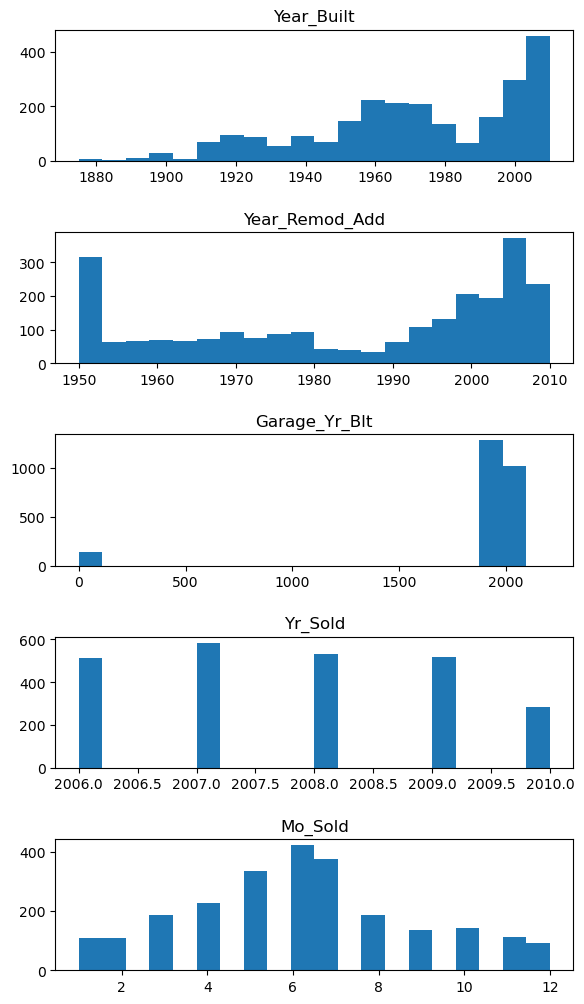

In [32]:
### Visualize the data
fig, ax = plt.subplots(5, 1)
fig.set_figwidth(6)
fig.set_figheight(10)
fig.tight_layout(h_pad=3)

for i in range(5):
    ax[i].set_title(year_columns[i])
    ax[i].hist(df[year_columns[i]], bins=20)

The inconsistencies are in `Garage_Yr_Blt`:  
- It can't have 0 as minimum. This means that the garage has not been built. Let's change this with the max values (2010)
- It can't have 2207 as maximum. I suppose that has been an error while writing 2007

In [33]:
### Manage the inconsistencies in 'Garage_Yr_Blt' column
df.loc[df['Garage_Yr_Blt'] == 2207, 'Garage_Yr_Blt'] = 2007
df.loc[df['Garage_Yr_Blt'] == 0, 'Garage_Yr_Blt'] = 2010

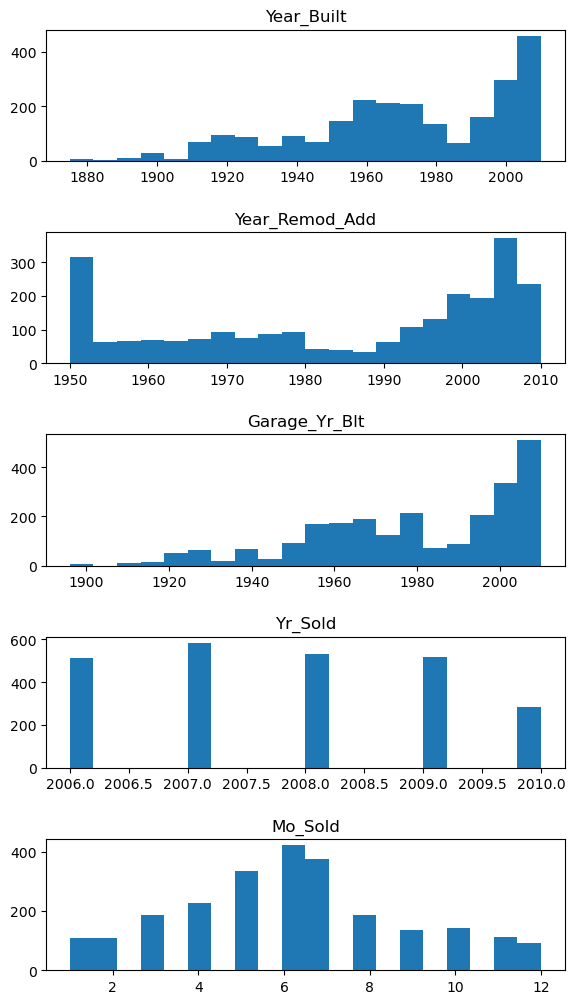

In [34]:
### Visualize the data after fixing them
fig, ax = plt.subplots(5, 1)
fig.set_figwidth(6)
fig.set_figheight(10)
fig.tight_layout(h_pad=3)

for i in range(5):
    ax[i].set_title(year_columns[i])
    ax[i].hist(df[year_columns[i]], bins=20)

### 2.1.1 Find inconsistencies in the size variables

To check the inconsistencies in the columns representing the area, let's make the following assumptions:
1. `BsmtFin_SF_1` + `BsmtFin_SF_2` + `Bsmt_Unf_SF` = `Total_Bsmt_SF`
2. `1st_Flr_SF` + `2nd_Flr_SF` + `Low_Qual_Fin_SF` = `Gr_Liv_Area`
3. `Lot_Area` $\ge$ `Wood_Deck_SF` + `Garage_Area` + `Pool_Area` + `Gr_Liv_Area`+  `Open_Porch_SF`+  `Enclosed_Porch`+  `3Ssn_Porch` + `Screen_Porch`
4. `TotRmsAbvGrd` - `BedroomAbvGr` - `KitchenAbvGr` $\ge$ 0

#### 2.1.1.1. `BsmtFin_SF_1` + `BsmtFin_SF_2` + `Bsmt_Unf_SF` = `Total_Bsmt_SF`

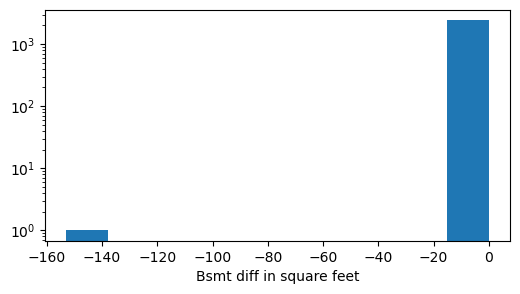

In [35]:
plt.figure(figsize=(6, 3))
a=plt.hist(df.eval('BsmtFin_SF_1 + BsmtFin_SF_2 + Bsmt_Unf_SF - Total_Bsmt_SF'))
plt.xlabel('Bsmt diff in square feet')
plt.yscale('log')

In [36]:
### Check the number of rows that are different from zero
df[df.eval('BsmtFin_SF_1 + BsmtFin_SF_2 + Bsmt_Unf_SF - Total_Bsmt_SF') != 0].shape[0]

1

There is one point that is not consistent with the assumptions. Let's drop this row

In [37]:
### Let's drom this row, keeping only the rows that have difference zero
df = df.loc[df[df.eval('BsmtFin_SF_1 + BsmtFin_SF_2 + Bsmt_Unf_SF - Total_Bsmt_SF') == 0].index]
df = df.reset_index(drop=True)
df.shape

(2429, 82)

#### 2.1.1.2. `1st_Flr_SF` + `2nd_Flr_SF` + `Low_Qual_Fin_SF` = `Gr_Liv_Area`

Text(0.5, 0, 'Above ground diff in square feet')

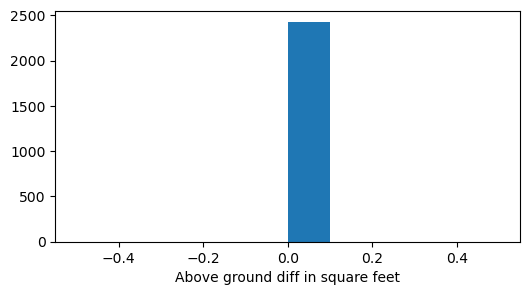

In [38]:
above_ground_columns = ['1st_Flr_SF', '2nd_Flr_SF', 'Low_Qual_Fin_SF']
plt.figure(figsize=(6, 3))
a=plt.hist(df[above_ground_columns].sum(axis=1) - df['Gr_Liv_Area'])
plt.xlabel('Above ground diff in square feet')

There is no inconsistency in `1st_Flr_SF`, `2nd_Flr_SF`, `Low_Qual_Fin_SF` and `Gr_Liv_Area`

#### 2.1.1.3. `Lot_Area` $\ge$ `Wood_Deck_SF` + `Garage_Area` + `Pool_Area` + `Gr_Liv_Area`+  `Open_Porch_SF`+  `Enclosed_Porch`+  `3Ssn_Porch` + `Screen_Porch`

The lot area is the full area of the property.  
For this reason `Lot_Area` has to be bigger than the sum of all the rooms at the ground level.

In [39]:
### Select the ground level columns
ground_columns = ['Wood_Deck_SF', 'Garage_Area', 'Pool_Area', 'Gr_Liv_Area', 'Open_Porch_SF', 'Enclosed_Porch', '3Ssn_Porch', 'Screen_Porch']

In [40]:
(df['Lot_Area'] - df[ground_columns].sum(axis=1)).describe()

count      2429.000000
mean       8097.136270
std        8170.842136
min        -874.000000
25%        5592.000000
50%        7329.000000
75%        9224.000000
max      212696.000000
dtype: float64

In [41]:
df[df['Lot_Area'] - df[ground_columns].sum(axis=1) < 0]

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
399,935,909451140,160,RM,24.0,1612,Pave,Grvl,Reg,Lvl,...,0,NA,MnPrv,Shed,0,7,2009,WD,Normal,121000
524,2731,905351045,150,RL,68.0,1700,Pave,Grvl,Reg,HLS,...,0,NA,MnPrv,Shed,0,4,2006,WD,Normal,148400
1224,1680,527451170,160,RM,24.0,1920,Pave,Grvl,Reg,Lvl,...,0,NA,MnPrv,Shed,0,8,2007,WD,Normal,122500
2044,408,527451650,160,RM,21.0,1680,Pave,Grvl,Reg,Lvl,...,0,NA,MnPrv,Shed,0,2,2009,WD,Normal,119500
2108,933,909451040,160,RM,24.0,1733,Pave,Grvl,Reg,Lvl,...,0,NA,GdPrv,Shed,0,5,2009,WD,Normal,115000
2270,2372,527451460,160,RM,21.0,1680,Pave,Grvl,Reg,Lvl,...,0,NA,GdPrv,Shed,0,10,2006,WD,Normal,108000


There are 6 rows with a smaller lot area. Let's temove them

In [42]:
### Let's drop this row, keeping only the rows that have difference >= 0
df = df.loc[df[df['Lot_Area'] - df[ground_columns].sum(axis=1) >= 0].index]
df = df.reset_index(drop=True)
df.shape

(2423, 82)

#### 2.1.1.4. `TotRmsAbvGrd` - `BedroomAbvGr` - `KitchenAbvGr` $\ge$ 0

`TotRms_AbvGrd` is the number of rooms above grade except bathroom.  

In [43]:
bedroom_columns = ['Bedroom_AbvGr', 'Full_Bath', 'Half_Bath', 'Kitchen_AbvGr', 'TotRms_AbvGrd']

In [44]:
### Let's print the statistic of the above formula
(df['TotRms_AbvGrd'] - df[['Bedroom_AbvGr', 'Kitchen_AbvGr']].sum(axis=1)).describe()

count    2423.000000
mean        2.524144
std         1.151299
min         0.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        12.000000
dtype: float64

The minimum value is 0 and the relation is satisfied

## 2.3 Handle outliers

In [45]:
df.shape

(2423, 82)

The dataframe contains 2423 rows.  
Removing any rows that appear to be outliers can result in large data loss.  
For this reason, it is necessary to examine the variables carefully.  

To remove the outliers, some features that could influence the price of the house were chosen: `Lot_Area`, `Gr_Liv_Area`, `Full_Bath`, `Bedroom_AbvGr`, `Total_Bsmt_SF`, `Garage_Area`, `TotRms_AbvGrd`

Text(0, 0.5, 'TotRms_AbvGrd')

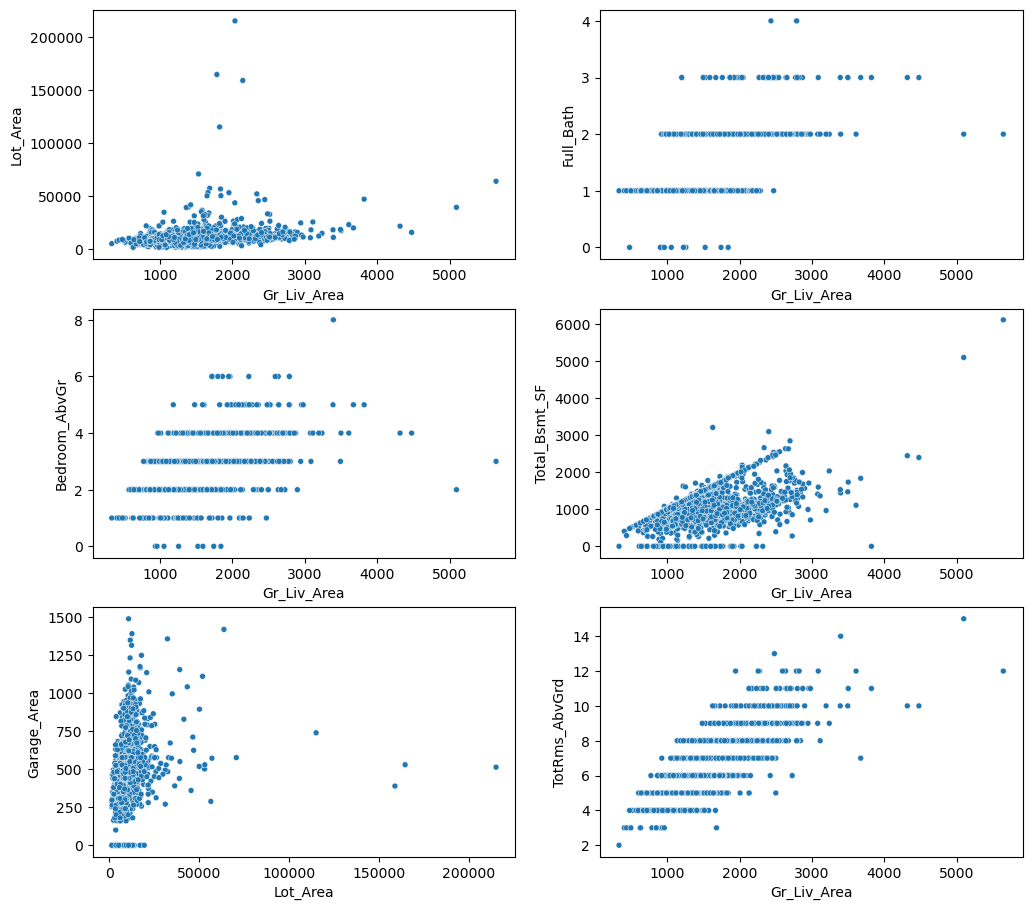

In [46]:
### Check for outliers
plt.figure(figsize=(12, 11))

plt.subplot(321)
sns.scatterplot(x=df['Gr_Liv_Area'], y=df['Lot_Area'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Lot_Area')

plt.subplot(322)
### Let's compare the total above grade living area and the number of bathrooms above the grade
sns.scatterplot(x=df['Gr_Liv_Area'], y=df['Full_Bath'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Full_Bath')

plt.subplot(323)
### Let's compare the total above grade living area and the number of bedrooms above the grade
sns.scatterplot(x=df['Gr_Liv_Area'], y=df['Bedroom_AbvGr'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Bedroom_AbvGr')

plt.subplot(324)
sns.scatterplot(x=df['Gr_Liv_Area'], y=df['Total_Bsmt_SF'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Total_Bsmt_SF')

plt.subplot(325)
sns.scatterplot(x=df['Lot_Area'], y=df['Garage_Area'], size=0.1, legend=None)
plt.xlabel('Lot_Area')
plt.ylabel('Garage_Area')

plt.subplot(326)
sns.scatterplot(x=df['Gr_Liv_Area'], y=df['TotRms_AbvGrd'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('TotRms_AbvGrd')

From the plot above there are just a few values that can be identified as outliers.  
Each feature was compared with another in order to identify extreme values.  
Let's analyze the plots one by one:  
- `Gr_Liv_Area` - `Lot_Area`: values for `Lot_Area` > 100000 and `Gr_Liv_Area` > 5000 can be identified as outliers
- `Gr_Liv_Area` - `Full_Bath`: values for `Full_Bath` > 3 can be identified as outliers
- `Gr_Liv_Area` - `Bedroom_AbvGr`: values for `Bedroom_AbvGr` > 4 and `Bedroom_AbvGr` < 1 can be identified as outliers
- `Gr_Liv_Area` - `Total_Bsmt_SF`: values for `Total_Bsmt_SF` > 4000 can be identified as outliers
- `Lot_Area` - `Garage_Area`: no value is a clear outlier
- `Gr_Liv_Area` - `TotRms_AbvGrd`:  no value is a clear outlier

<Axes: >

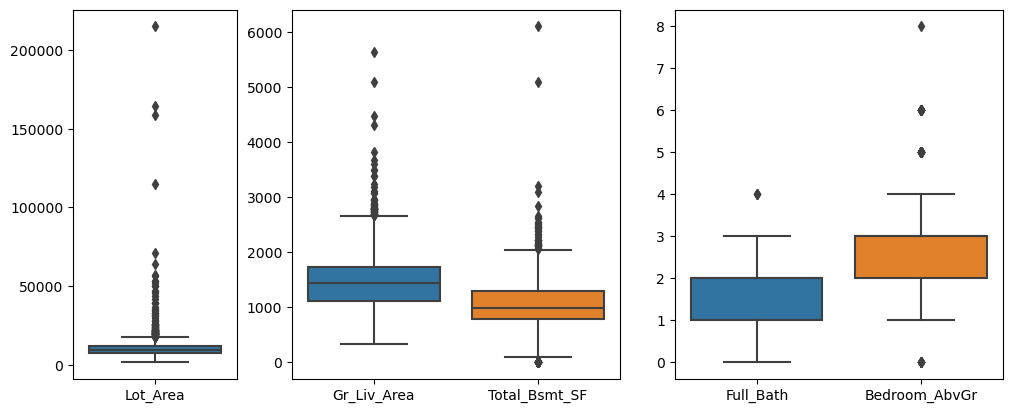

In [47]:
### Let's create boxplots with these features
fig, ax = plt.subplots(1, 3, width_ratios=(1, 2, 2))
fig.set_figwidth(12)
sns.boxplot(df[['Lot_Area']], ax=ax[0])
sns.boxplot(df[['Gr_Liv_Area', 'Total_Bsmt_SF']], ax=ax[1])
sns.boxplot(df[['Full_Bath', 'Bedroom_AbvGr']], ax=ax[2])

The distributions are skewed. Let's use a log transofrmation to make them more simmetric

C:\Users\enric\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: >

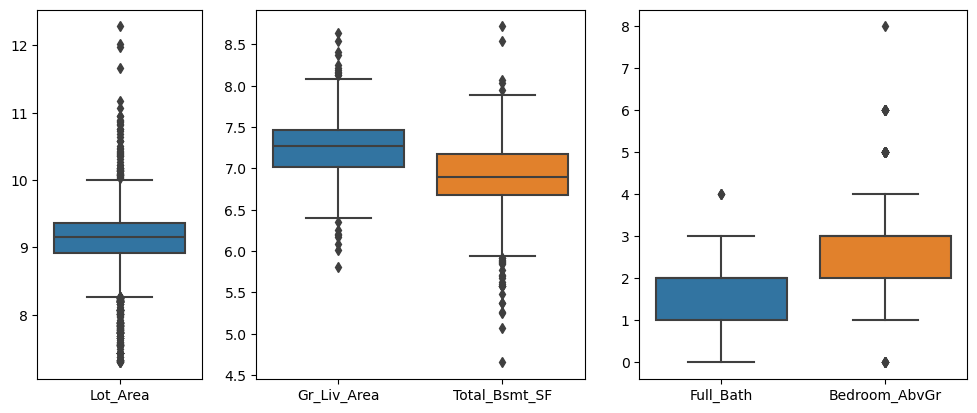

In [48]:
### Let's create boxplots with these features
fig, ax = plt.subplots(1, 3, width_ratios=(1, 2, 2))
fig.set_figwidth(12)
sns.boxplot(np.log(df[['Lot_Area']]), ax=ax[0])
sns.boxplot(np.log(df[['Gr_Liv_Area', 'Total_Bsmt_SF']]), ax=ax[1])
sns.boxplot(df[['Full_Bath', 'Bedroom_AbvGr']], ax=ax[2])

It is possible to use the **z-score** with the log transformation to remove the outliers.
- `Lot_Area`, `Gr_Liv_Area` and `Total_Bsmt_SF` will be removed with the **z-score**
- `Full_Bath` and `Bedroom_AbvGr` will be removed manually

In [49]:
### Define a function to remove outliers
def remove_outliers(col):
    z = np.abs(stats.zscore(col))
    z_method = col.loc[np.where(abs(z) <= 2)]
    return z_method

In [50]:
df_sub = df.copy()
df_sub.loc[:, 'Bedroom_AbvGr'] = df.loc[df_sub[(df_sub['Bedroom_AbvGr'] <= 4) & (df_sub['Bedroom_AbvGr'] >= 1)].index, 'Bedroom_AbvGr']
df_sub.loc[:, 'Full_Bath'] = df.loc[df_sub[df_sub['Full_Bath'] <= 3].index, 'Full_Bath']

In [51]:
### Define the columns to transform in log scale
outlier_columns = ['Lot_Area', 'Gr_Liv_Area', 'Total_Bsmt_SF']

### Create the new columns in log scale the columns keeping the zeros
outlier_log_columns = ['Lot_Area_log', 'Gr_Liv_Area_log', 'Total_Bsmt_SF_log']
df_sub[outlier_log_columns] = df_sub[outlier_columns]
df_sub[outlier_log_columns] = df_sub[outlier_log_columns].apply(lambda x: x.apply(lambda y: 0 if y == 0 else round(np.log(y))))

### Remove outliers using the z-score
df_sub[outlier_log_columns] = df_sub[outlier_log_columns].apply(lambda x: remove_outliers(x))
### The function remove_outliers generated missing values at the positions of the outliers. 
### Let's drop these missing values
df_sub = df_sub.dropna()
### Drop the log columns
df_sub = df_sub.drop(columns=outlier_log_columns)
df_sub = df_sub.reset_index(drop=True)
print(f'The { round(100*(1 - df_sub.shape[0]/df.shape[0]), 2) }% of the data have been removed')

The 7.76% of the data have been removed


Text(0, 0.5, 'TotRms_AbvGrd')

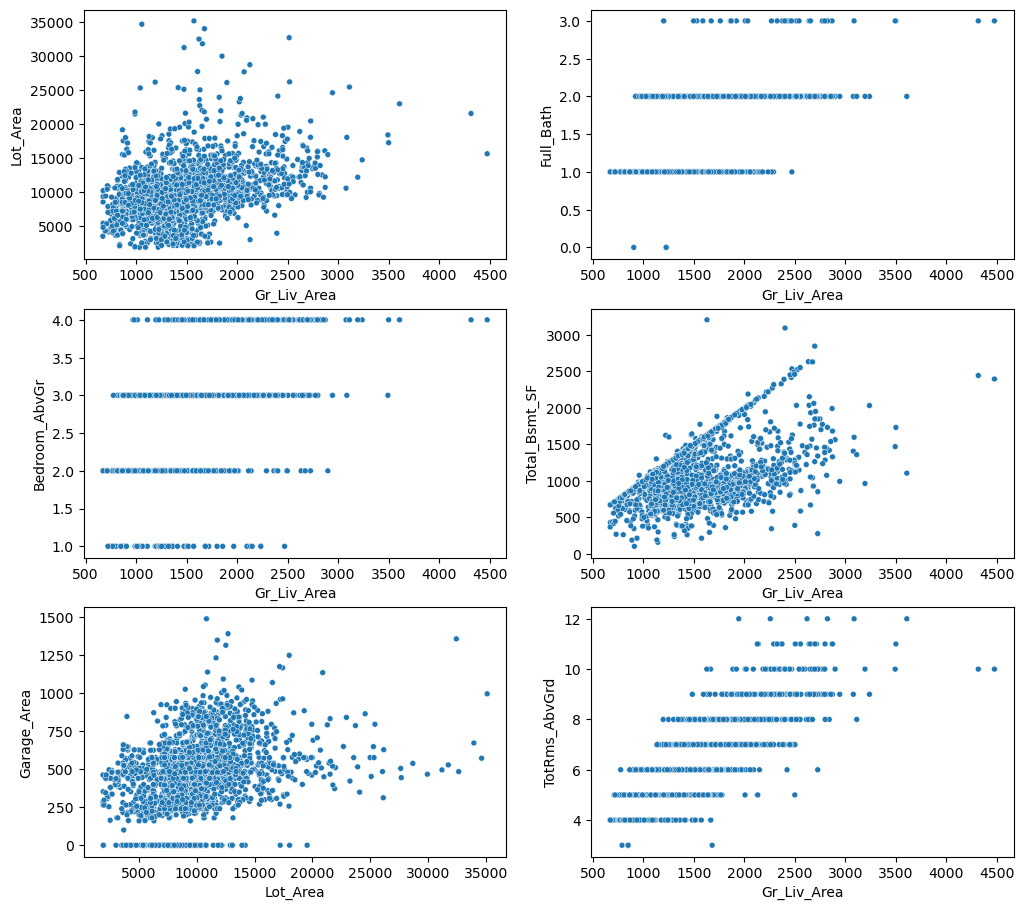

In [52]:
plt.figure(figsize=(12, 11))

plt.subplot(321)
sns.scatterplot(x=df_sub['Gr_Liv_Area'], y=df_sub['Lot_Area'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Lot_Area')

plt.subplot(322)
### Let's compare the total above grade living area and the number of bathrooms above the grade
sns.scatterplot(x=df_sub['Gr_Liv_Area'], y=df_sub['Full_Bath'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Full_Bath')

plt.subplot(323)
### Let's compare the total above grade living area and the number of bedrooms above the grade
sns.scatterplot(x=df_sub['Gr_Liv_Area'], y=df_sub['Bedroom_AbvGr'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Bedroom_AbvGr')

plt.subplot(324)
sns.scatterplot(x=df_sub['Gr_Liv_Area'], y=df_sub['Total_Bsmt_SF'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('Total_Bsmt_SF')

plt.subplot(325)
sns.scatterplot(x=df_sub['Lot_Area'], y=df_sub['Garage_Area'], size=0.1, legend=None)
plt.xlabel('Lot_Area')
plt.ylabel('Garage_Area')

plt.subplot(326)
sns.scatterplot(x=df_sub['Gr_Liv_Area'], y=df_sub['TotRms_AbvGrd'], size=0.1, legend=None)
plt.xlabel('Gr_Liv_Area')
plt.ylabel('TotRms_AbvGrd')

<Axes: >

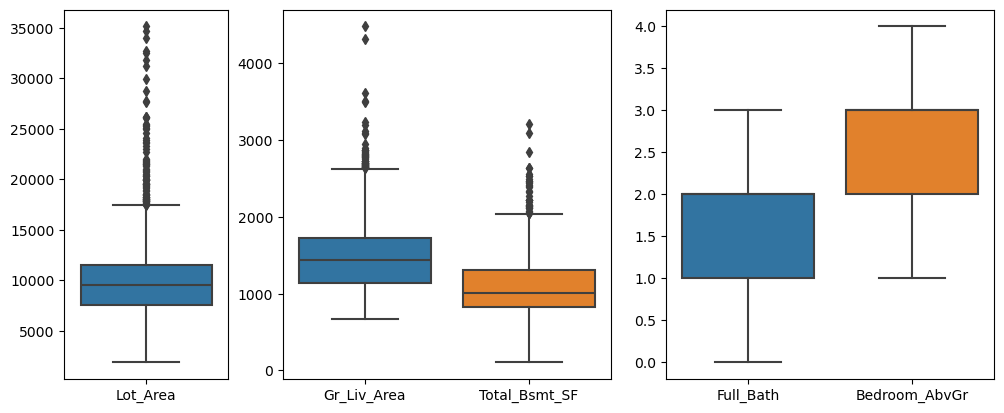

In [53]:
### Let's create boxplots with these features
fig, ax = plt.subplots(1, 3, width_ratios=(1, 2, 2))
fig.set_figwidth(12)
sns.boxplot(df_sub[['Lot_Area']], ax=ax[0])
sns.boxplot(df_sub[['Gr_Liv_Area', 'Total_Bsmt_SF']], ax=ax[1])
sns.boxplot(df_sub[['Full_Bath', 'Bedroom_AbvGr']], ax=ax[2])

<Axes: >

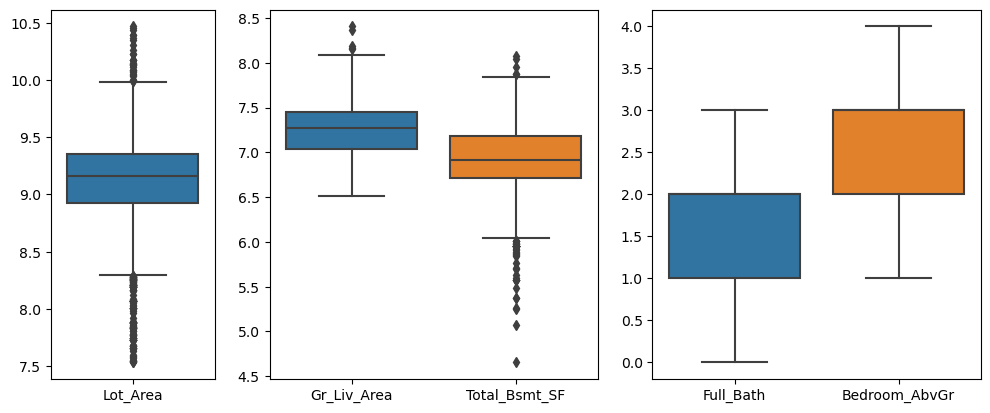

In [54]:
### Let's create boxplots with these features
fig, ax = plt.subplots(1, 3, width_ratios=(1, 2, 2))
fig.set_figwidth(12)
sns.boxplot(np.log(df_sub[['Lot_Area']]), ax=ax[0])
sns.boxplot(np.log(df_sub[['Gr_Liv_Area', 'Total_Bsmt_SF']]), ax=ax[1])
sns.boxplot(df_sub[['Full_Bath', 'Bedroom_AbvGr']], ax=ax[2])

# 3. Feature engineering

After the year 2000 the price increases more.  
Let's create 2 new variables:  
- `After_2000_built` with values 0 (`Year_Built` < 2000) and 1 (`Year_Built` > 2000)
- `After_2000_RemAdd` with values 0 (`Year_Remode_Add` < 2000) and 1 (`Year_Remode_Add` > 2000)

<Axes: xlabel='Year_Built', ylabel='SalePrice'>

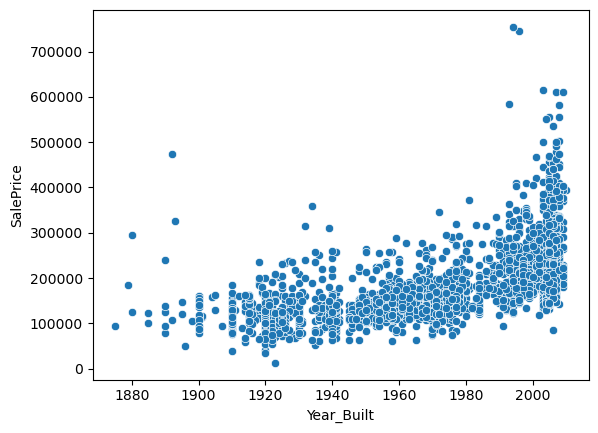

In [55]:
sns.scatterplot(x=df_sub.Year_Built, y=df_sub.SalePrice)

In [56]:
df_sub['After_2000_built'] = np.nan
df_sub['After_2000_RemAdd'] = np.nan

df_sub.loc[df_sub[df_sub.Year_Built < 2000].index, 'After_2000_built'] = 0
df_sub.loc[df_sub[df_sub.Year_Built >= 2000].index, 'After_2000_built'] = 1

df_sub.loc[df_sub[df_sub.Year_Remod_Add < 2000].index, 'After_2000_RemAdd'] = 0
df_sub.loc[df_sub[df_sub.Year_Remod_Add >= 2000].index, 'After_2000_RemAdd'] = 1

There is no variable representing if the house has or not a porch.  
Let's create a variable named `Tot_Porch_Area` by summing all the porch columns and then create a `Porch` feature:
- `Porch` = 0 if `Tot_Porch_Area`= 0
- `Porch` = 1 if `Tot_Porch_Area`> 0

In [57]:
df_sub['Tot_Porch_Area'] = df_sub[['Open_Porch_SF', 'Enclosed_Porch', '3Ssn_Porch', 'Screen_Porch']].sum(axis=1)

df_sub['Porch'] = np.nan

df_sub.loc[df_sub[df_sub.Tot_Porch_Area == 0].index, 'Porch'] = 0
df_sub.loc[df_sub[df_sub.Tot_Porch_Area > 0].index, 'Porch'] = 1

There is no variable representing if the house has or not a porch.  
Let's create a variable named `2nd_Floor` representing if the house has a second floor:
- `2nd_Floor` = 0 if `2nd_Flr_SF`= 0
- `2nd_Floor` = 1 if `2nd_Flr_SF`> 0

In [58]:
df_sub['2nd_Floor'] = np.nan

df_sub.loc[df_sub[df_sub['2nd_Flr_SF'] == 0].index, '2nd_Floor'] = 0
df_sub.loc[df_sub[df_sub['2nd_Flr_SF'] > 0].index, '2nd_Floor'] = 1

In [59]:
### Create a variable 'Tot_Rooms' representing the number of total room including bathrooms
df_sub['Tot_Rooms'] = df_sub.eval('Full_Bath + Half_Bath + TotRms_AbvGrd')
df_sub[['Full_Bath', 'Half_Bath', 'TotRms_AbvGrd', 'Tot_Rooms', 'SalePrice']].corr()

,Full_Bath,Half_Bath,TotRms_AbvGrd,Tot_Rooms,SalePrice
Full_Bath,1.000000,0.161261,0.502927,0.667961,0.558051
Half_Bath,0.161261,1.000000,0.376365,0.562470,0.280828
TotRms_AbvGrd,0.502927,0.376365,1.000000,0.947669,0.522665
Tot_Rooms,0.667961,0.562470,0.947669,1.000000,0.594571
SalePrice,0.558051,0.280828,0.522665,0.594571,1.000000


In [60]:
### Create a variable 'Avg_room_size' representing the average room size
df_sub['Avg_Room_Size'] = df_sub.Gr_Liv_Area/df_sub.TotRms_AbvGrd
df_sub[['TotRms_AbvGrd', 'Gr_Liv_Area', 'Avg_Room_Size', 'SalePrice']].corr()

,TotRms_AbvGrd,Gr_Liv_Area,Avg_Room_Size,SalePrice
TotRms_AbvGrd,1.000000,0.795797,0.072339,0.522665
Gr_Liv_Area,0.795797,1.000000,0.642377,0.734989
Avg_Room_Size,0.072339,0.642377,1.000000,0.534948
SalePrice,0.522665,0.734989,0.534948,1.000000


# 4. Feature encoding

Apply the One-Hot-Encoding to the categorical variables.  
Some features have values that are numerical, but they represent a categorical.  
Let's convert these to categorical

In [61]:
### Convert numerical features to categorical
features_to_convert = ['MS_SubClass', 'After_2000_built', 'After_2000_RemAdd',  'Porch', '2nd_Floor']
df_sub[features_to_convert] = df_sub[features_to_convert].astype(str)
df_sub[features_to_convert].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   MS_SubClass        2235 non-null   object
 1   After_2000_built   2235 non-null   object
 2   After_2000_RemAdd  2235 non-null   object
 3   Porch              2235 non-null   object
 4   2nd_Floor          2235 non-null   object
dtypes: object(5)
memory usage: 87.4+ KB


In [62]:
### Create input and output
X = df_sub.drop(columns=['Order', 'PID', 'SalePrice'])
y = df_sub.SalePrice

In [63]:
### Create the new list of categorical features for the encoder
OH_cat_features = [x for x in X.columns if X[x].dtypes == 'object']
### Create the new list of numerical features
OH_num_features = [x for x in X.columns if X[x].dtypes != 'object']

In [64]:
### Create a One-Hot Encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
### Concatenate the encoded dataset with the numerical features dataset
encoded_X = pd.concat([X[OH_num_features], pd.DataFrame(OH_encoder.fit_transform(X[OH_cat_features]))], axis=1)

# 5. Splitting data

Split the data in training and validation.  
The column names after the One-Hot encoding are **int** type, it is necessary that they are strings

In [65]:
### Convert the column names in strings
encoded_X.columns = encoded_X.columns.astype(str)

In [66]:
### Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(encoded_X, y, test_size=0.2)

# 6. Model fitting

In [67]:
### Select the best 15 features correlated with the sale price
best_features = list(df_sub[OH_num_features + ['SalePrice']].corr().loc['SalePrice'].abs().sort_values(ascending=False).index[1:16])

## 6.1 Baseline

Let's create a baseline model using only one feature.  
For this the area of the lot has been chosen 

In [68]:
### Define the model
print(f'Feature to use for baseline: {best_features[0]}')
baseline_model = LinearRegression()
baseline_model.fit(np.reshape(X_train[best_features[0]], newshape=(-1, 1)), y_train)
y_pred_base = baseline_model.predict(np.reshape(X_valid[best_features[0]], newshape=(-1, 1)))
mae_base = mean_absolute_error(y_valid, y_pred_base)
print(f'The MAE for the baseline model is {mae_base}')

Feature to use for baseline: Overall_Qual
The MAE for the baseline model is 34918.16725012875


## 6.2 Simple model with two variables

In [69]:
print(f'Feature to use for simple model: {best_features[:2]}')
simple_model = LinearRegression()
simple_model.fit(X_train[best_features[:2]], y_train)
y_pred_simple = simple_model.predict(X_valid[best_features[:2]])
mae_simple = mean_absolute_error(y_valid, y_pred_simple)
print(f'The MAE for the simple model is {mae_simple}')

Feature to use for simple model: ['Overall_Qual', 'Gr_Liv_Area']
The MAE for the simple model is 30079.079546053974


## 6.3 Intermediate model (15 variables)

In [70]:
print(f'Feature to use for intermediate model: {best_features}')
intermediate_model = LinearRegression()
intermediate_model.fit(X_train[best_features], y_train)
y_pred_intermediate = intermediate_model.predict(X_valid[best_features])
mae_intermediate = mean_absolute_error(y_valid, y_pred_intermediate)
print(f'The MAE for the intermediate model is {mae_intermediate}')

Feature to use for intermediate model: ['Overall_Qual', 'Gr_Liv_Area', 'Total_Bsmt_SF', '1st_Flr_SF', 'Garage_Cars', 'Garage_Area', 'Tot_Rooms', 'Year_Built', 'Full_Bath', 'Avg_Room_Size', 'Mas_Vnr_Area', 'Year_Remod_Add', 'TotRms_AbvGrd', 'Fireplaces', 'Garage_Yr_Blt']
The MAE for the intermediate model is 22718.061875534408


## 6.4 Complex model with all variables

In [71]:
complex_model = LinearRegression()
complex_model.fit(X_train, y_train)
y_pred_complex = complex_model.predict(X_valid)
mae_complex = mean_absolute_error(y_valid, y_pred_complex)
print(f'The MAE for the complex model is {mae_complex}')
print(f'The training MAE for the complex model is {mean_absolute_error(y_train, complex_model.predict(X_train))}')

The MAE for the complex model is 87994862.2417881
The training MAE for the complex model is 12798.42575546879


Using LinearRegression for the complex model results in a huge mean absolute error for validation and a much lower error for training.  
The model is fitting the training data too precisely such that adding new data can result in a large error.  
This means that, while minimizing the loss function, the coefficients of the linear function can get too large and a small variation of the input can result in a large error.
This is a result of overfitting, i.e. the model is to complex, many feautures (335) with respect to the observations (2354).  
Using a model that include a regularization term, it is possible to add a constraint to the coefficients.

In [72]:
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_valid)
mae_ridge = mean_absolute_error(y_valid, y_pred_ridge)
print(f'The MAE for the Ridge model is {mae_ridge}')
print(f'The training MAE for the Ridge model is {mean_absolute_error(y_train, ridge_model.predict(X_train))}')

The MAE for the Ridge model is 15789.606597744656
The training MAE for the Ridge model is 12905.176186959836


Using Ridge, the resulting MAE is the smallest compared with the previous models.

# 7. Hyperparameter tuning

It has been seen that using a model that includes regularization decreases the uncertainty on the predictions  
Let's tune the $\alpha$ hyperparameter of $L_2$ regularization to obtain a lower error.

## 7.1. $L_2$ regularization

In [73]:
### Define the estimator model
estim_model = Ridge()

### Apply a L2 regularization
alphas = np.logspace(-5, 8, num=50)

### Define the parameters for grid search
params = {
    'alpha': alphas,
}

### Define a grid search
grid_model = GridSearchCV(estim_model, param_grid=params, cv=5, scoring='neg_mean_absolute_error',return_train_score=True)
### Fit the model
grid_model.fit(X_train, y_train)
### Compute the MAE for the validation
mae_grid = mean_absolute_error(y_valid, grid_model.best_estimator_.predict(X_valid))

print(f'The best alpha is {grid_model.best_params_}')
print(f'The best GridSearch MAE is {grid_model.best_score_}')
print(f'The best validation MAE is {mae_grid}')

The best alpha is {'alpha': 12.648552168552984}
The best GridSearch MAE is -14889.35803513221
The best validation MAE is 15432.281236428684


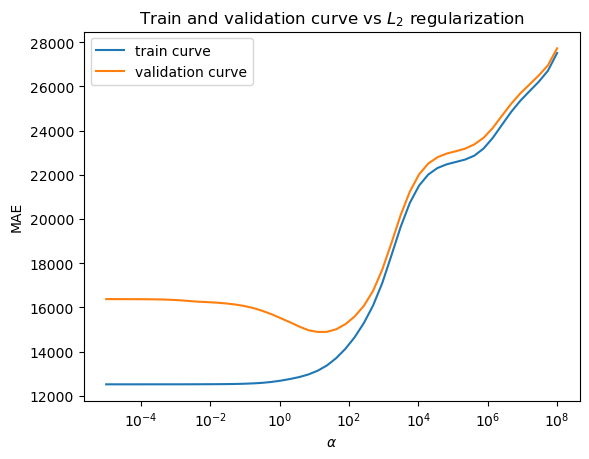

In [74]:
### Plot training and validation curve
plt.title(r'Train and validation curve vs $L_2$ regularization')
plt.plot(alphas, np.abs(grid_model.cv_results_['mean_train_score']), label='train curve')
plt.plot(alphas, np.abs(grid_model.cv_results_['mean_test_score']), label='validation curve')
plt.xlabel(r'$\alpha$')
plt.ylabel('MAE')
plt.xscale('log')
plt.legend()

# 8. Evaluate the results

Text(0, 0.5, 'MAE')

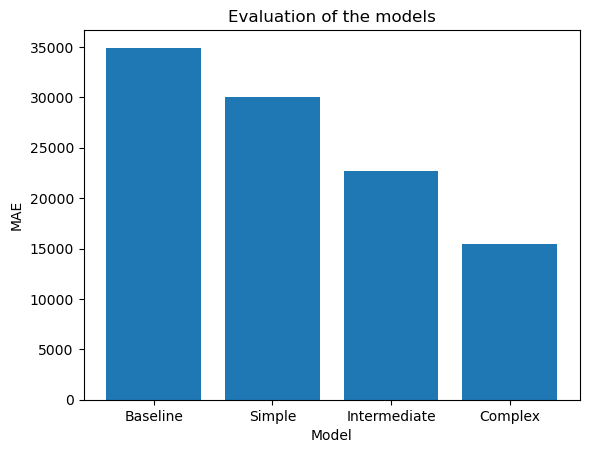

In [75]:
mae_all = [mae_base, mae_simple, mae_intermediate, mae_grid]
names = ['Baseline', 'Simple', 'Intermediate', 'Complex']

plt.title('Evaluation of the models')
plt.bar(names, mae_all)
plt.xlabel('Model')
plt.ylabel('MAE')

# 9. Predicting on test data

In [76]:
test_dataset = pd.read_csv('house-prices-test.csv')

In [77]:
test_dataset.columns = test_dataset.columns.str.replace(' ', '_').str.replace('/', '_')

In [78]:
test_dataset.isna().sum().sum()

2637

It is necessary to process the test dataset before making predictions:
1. Replace with 0 (for numerical) and 'NA' (for categoricaò) the houses that do not have that specific features
2. Create the new variables created for the the training set
3. Fill the missing values with the median (for numerical) and the most frequent (for categorical)

## 9.1 Replace with 0 (for numerical) and 'NA' (for categorical) the houses that do not have that specific features

In [79]:
test_dataset.loc[test_dataset[(test_dataset[garage_num_columns] == 0).any(axis=1) == True].index, garage_num_columns] = 0
test_dataset.loc[test_dataset[test_dataset['Total_Bsmt_SF'] == 0].index, bsmt_num_columns] = 0
test_dataset.loc[test_dataset[(test_dataset[garage_num_columns] == 0).all(axis=1) == True].index, garage_cat_columns] = 'NA'
test_dataset.loc[test_dataset[test_dataset['Total_Bsmt_SF'] == 0].index, bsmt_cat_columns] = 'NA'
test_dataset.loc[test_dataset[test_dataset['Pool_Area'] == 0].index, 'Pool_QC'] = 'NA'
test_dataset.loc[test_dataset[test_dataset['Garage_Type'] == '2Types'].index, 'Misc_Feature'] = 'Gar2'
test_dataset.loc[test_dataset[test_dataset['Fireplaces'] == 0].index, 'Fireplace_Qu'] = 'NA'
test_dataset.loc[test_dataset[test_dataset['Mas_Vnr_Area'] == 0].index, 'Mas_Vnr_Type'] = 'NA'

## 9.2 Create the new variables created for the training set

In [80]:
test_dataset['After_2000_built'] = np.nan
test_dataset['After_2000_RemAdd'] = np.nan
test_dataset.loc[test_dataset[test_dataset.Year_Built < 2000].index, 'After_2000_built'] = 0
test_dataset.loc[test_dataset[test_dataset.Year_Built >= 2000].index, 'After_2000_built'] = 1
test_dataset.loc[test_dataset[test_dataset.Year_Remod_Add < 2000].index, 'After_2000_RemAdd'] = 0
test_dataset.loc[test_dataset[test_dataset.Year_Remod_Add >= 2000].index, 'After_2000_RemAdd'] = 1

test_dataset['Tot_Porch_Area'] = test_dataset[['Open_Porch_SF', 'Enclosed_Porch', '3Ssn_Porch', 'Screen_Porch']].sum(axis=1)
test_dataset['Porch'] = np.nan
test_dataset.loc[test_dataset[test_dataset.Tot_Porch_Area == 0].index, 'Porch'] = 0
test_dataset.loc[test_dataset[test_dataset.Tot_Porch_Area > 0].index, 'Porch'] = 1

test_dataset['2nd_Floor'] = np.nan
test_dataset.loc[test_dataset[test_dataset['2nd_Flr_SF'] == 0].index, '2nd_Floor'] = 0
test_dataset.loc[test_dataset[test_dataset['2nd_Flr_SF'] > 0].index, '2nd_Floor'] = 1

test_dataset['Tot_Rooms'] = test_dataset.eval('Full_Bath + Half_Bath + TotRms_AbvGrd')

test_dataset['Avg_Room_Size'] = test_dataset.Gr_Liv_Area/test_dataset.TotRms_AbvGrd

### Convert numerical features to categorical
features_to_convert = ['MS_SubClass', 'After_2000_built', 'After_2000_RemAdd',  'Porch', '2nd_Floor']
test_dataset[features_to_convert] = test_dataset[features_to_convert].astype(str)


## 9.3 Fill the missing values with the median (for numerical) and the most frequent (for categorical)

In [81]:
### Fill the missing values in numerical columns with the median value
numerical_transformer = SimpleImputer(strategy='median')
### Fill the missing values in categorical columns with the most frequent value
categorical_transformer = SimpleImputer(strategy='most_frequent')
### Create a list of the remaing columns with missing values
missing_columns = (test_dataset.isna().sum()[test_dataset.columns[test_dataset.isna().sum() > 0]].sort_values(ascending=False)).index
### Create a list of the remaining numerical variables
missing_num_columns = [x for x in missing_columns if test_dataset[missing_columns][x].dtypes != 'object']
### Create a list of the remaining categorical variables
missing_cat_columns = [x for x in missing_columns if test_dataset[missing_columns][x].dtypes == 'object']
### Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, missing_num_columns),
        ('cat', categorical_transformer, missing_cat_columns)
    ])
### Fill the missing values by transforming
test_dataset.loc[:, missing_num_columns + missing_cat_columns] = preprocessor.fit_transform(test_dataset[missing_num_columns + missing_cat_columns])



## 9.4 Apply One-Hot Encoding

The encoding has to be applied using `OH_encoder`, pre-fitted for the training data. 

In [82]:
encoded_test_dataset = test_dataset.copy()
### Concatenate the encoded dataset with the numerical features dataset
encoded_test_dataset = pd.concat([encoded_test_dataset[OH_num_features], 
                                  pd.DataFrame(OH_encoder.transform(encoded_test_dataset[OH_cat_features]))], axis=1)

In [83]:
### Convert the column names in strings
encoded_test_dataset.columns = encoded_test_dataset.columns.astype(str)

## 9.5 Make predictions

In [84]:
### Create predictions datasets for simple, intermediate and complex models
prediction_simple = test_dataset[['PID']].copy()
prediction_intermediate = test_dataset[['PID']].copy()
prediction_complex = test_dataset[['PID']].copy()

In [85]:
### Predict the test dataset
prediction_simple['SalePrice'] = simple_model.predict(encoded_test_dataset[best_features[:2]])
prediction_intermediate['SalePrice'] = intermediate_model.predict(encoded_test_dataset[best_features])
prediction_complex['SalePrice'] = grid_model.predict(encoded_test_dataset)

## 9.6 Submit the results

In [86]:
### Save the prediction datasets in csv files
prediction_simple.to_csv('predictions-simple-model.csv', index=False)
prediction_intermediate.to_csv('predictions-intermediate-model.csv', index=False)
prediction_complex.to_csv('predictions-complex-model.csv', index=False)